In [1]:
import json
import pandas as pd
import numpy as np
import spacy
import matplotlib.pyplot as plot
pd.options.display.max_rows = 999
from gensim import models,corpora,similarities
from gensim.models.coherencemodel import CoherenceModel


In [2]:
nlp = spacy.load("en_core_web_md",disable=['parser','ner'])

## Loading the data

Using json for serializing the data is not ideal. it won't translate well to a python dictionary. But lets imagine that we got it as an API response.
Here we see the first issue is that scene number is not an integer anymore, it's a string. Below function will load the data and convert a string number to an integer.    


In [3]:
def read_json_script(filename):
    with open(filename, "r") as f:
        script=json.load(f)
        return {int(k): v for k, v in script.items()}

In [4]:
def tokenizer(doc):
    return [token.lemma_ for token in doc if token.is_alpha 
            and not token.is_stop 
            and not token.is_punct
            and not token.is_space
            and token.pos_ in ['NOUN','VERB','ADJ']]

In [22]:
script=read_json_script("joker.json")

I'm going to make a Dataframe and transpose it, to make scene numbers to be indecies

In [23]:
df=pd.DataFrame(script).T

Replacing empty lists with NaNs

`tod` (time of day) column has `CONTINUOUS` string. `CONTINUOUS` means the scene takes place in the same time of day as the scene before. In this case `CONTINUOUS` would not mean much. 
It would make sense to replace  `CONTINUOUS` with the value of the row before.
Let's use `.assign()` here.  I got this way of working from @Matt_Harrison and I find it very neat. 

In [24]:
df=df.assign(
    transitions=df['transitions'].apply(lambda x: x if x!=[] else np.nan),
    dialog=df['dialog'].apply(lambda x: x if x!={} else np.nan),
    tod=(df['tod']
         .replace('CONTINUOUS', np.nan).ffill()
         .replace('LATER', np.nan).ffill()),
    
    # action=df['action'].apply(lambda col:[sent for sent in nlp(' '.join(col)).sents])
          
          )

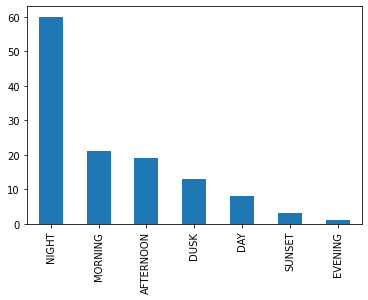

In [18]:
df['tod'].value_counts().plot.bar();

_____________


In [9]:
test=df.action.loc[:3].to_list()

In [10]:
tokenized=list(map(tokenizer, nlp.pipe([''.join(t) for t in test],n_process=4)))

In [72]:
num_topics=3

In [73]:
dictionary=corpora.Dictionary(tokenized)


In [74]:
# dictionary.filter_extremes(no_below=1 ,no_above=0.1)

In [75]:
corpus_bow=[dictionary.doc2bow(article) for article in tokenized]

In [76]:
lda_model=models.LdaModel(corpus=corpus_bow, 
                          num_topics=num_topics,
                          id2word=dictionary,
                          passes=2,
                          alpha='auto',
                          eta='auto')

In [77]:
lda_model.print_topics()

[(0,
  '0.030*"sign" + 0.018*"kid" + 0.017*"pick" + 0.017*"boy" + 0.014*"get" + 0.014*"street" + 0.014*"hold" + 0.013*"old" + 0.013*"kick" + 0.013*"music"'),
 (1,
  '0.019*"look" + 0.014*"journal" + 0.014*"beat" + 0.014*"pause" + 0.014*"hang" + 0.013*"run" + 0.010*"give" + 0.010*"laugh" + 0.010*"sit" + 0.010*"worker"'),
 (2,
  '0.016*"sign" + 0.016*"kid" + 0.016*"hit" + 0.015*"face" + 0.015*"street" + 0.014*"take" + 0.014*"turn" + 0.014*"beating" + 0.014*"ground" + 0.011*"beat"')]

In [ ]:
print(lda_model.alpha)
print(lda_model.eta)

In [98]:
topics=sorted(lda_model.get_document_topics(corpus_bow[1]),key=lambda tup: tup[1])

In [99]:
lda_model.show_topic(topics[0][0])

[('sign', 0.030081015),
 ('kid', 0.01770373),
 ('pick', 0.01738223),
 ('boy', 0.01653859),
 ('get', 0.014117313),
 ('street', 0.014068894),
 ('hold', 0.0135454275),
 ('old', 0.01332013),
 ('kick', 0.013259685),
 ('music', 0.013022451)]

In [100]:
topics

[(0, 0.99078935)]

_________


### FEATURE ENGINEERING
- number of charachters
- 

In [22]:
                                                                                                                                                           
len(df.dialog[1])

2

In [23]:
df1=df.copy()

In [24]:
df['int_ext'].value_counts(normalize=True)*100

INT.    70.4
EXT.    29.6
Name: int_ext, dtype: float64

In [25]:
df['tod'].value_counts(normalize=True)*100

NIGHT        48.0
MORNING      16.8
AFTERNOON    15.2
DUSK         10.4
DAY           6.4
SUNSET        2.4
EVENING       0.8
Name: tod, dtype: float64

In [26]:
df['transitions'].value_counts()

[CUT TO:]                                 20
[BACK TO:, CUT BACK TO:, CUT BACK TO:]     3
[TITLE:]                                   1
[QUICK CUTS:]                              1
[CUT TO:, CUT TO:]                         1
[CUT TO BLACK, FADE IN:]                   1
[IRIS OUT:]                                1
Name: transitions, dtype: int64

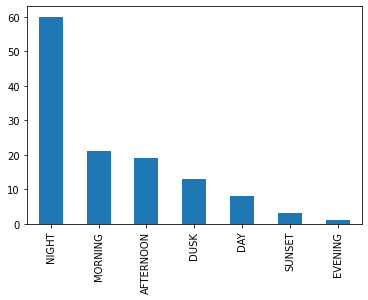

In [14]:
df['tod'].value_counts().plot.bar();

In [ ]:
[token.lemma_ for token in doc if token.is_alpha and not token.is_stop]
    

In [496]:
[(token.text, token.label_) for token in doc.ents ]


[('CLOSE ON ARTHUR', 'ORG'),
 ('30', 'CARDINAL'),
 ('years', 'DATE'),
 ('50', 'CARDINAL'),
 ('African American', 'NORP'),
 ('Arthur', 'PERSON'),
 ('days', 'DATE'),
 ('half', 'CARDINAL'),
 ('journal--', 'NORP'),
 ("Arthur's", 'ORG'),
 ('Arthur', 'ORG')]

In [549]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
list([t.lower_ for t in doc if t.is_alpha and not t.is_stop])

In [583]:
sentences=list([t.text for t in doc.sents])

In [606]:
def spacy_tokinizer(doc):

    return [t.text for t in nlp(doc) if t.is_alpha and not t.is_punct]
    

In [613]:
cv=CountVectorizer(tokenizer=spacy_tokinizer,ngram_range=(2,2),lowercase=True,binary=True)

In [614]:
cv.fit_transform(sentences)

<33x240 sparse matrix of type '<class 'numpy.int64'>'
	with 248 stored elements in Compressed Sparse Row format>